## ImageNet vs. Synthetic dataset에 대해서 confidence 비교

### 클래스 별 동일한 이미지

- 기능 1: ImageNet 데이터셋에서 class 별 N 장의 이미지 샘플링

- 기능 2: Synthetic 데이터셋을 class 별 N 장씩 생성

- 기능 3: ImageNet/Synthetic 데이터셋과 모델이 주어졌을 때, confidence 계산

- 기능 4: confidence를 입력으로 받았을 때, histgram을 그리기

#### 기본 환경 설정

In [27]:
import os
import sys
import glob
import random
from typing import List, Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from utils import build_model

In [16]:
# Environment
def set_seed(seed):
    sys.setrecursionlimit(100000)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True, warn_only=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # TODO: 서버 사용 현황에 따라서 수정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

seed = 0 # TODO: robustness 측정을 위해 변경
set_seed(seed)

# pyploy 환경 설정
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

print("Environment setup completed.")

Using Device: cuda
Environment setup completed.


In [49]:
# 기본 설정값 (데이터셋 경로/모델 등)
def get_teacher(name):
    teacher_name = {'deit_tiny_16_imagenet': 'deit_tiny_patch16_224',
                    'deit_base_16_imagenet': 'deit_base_patch16_224',
                    }
    if name.split("_")[-1]=='imagenet':
        teacher=build_model(teacher_name[name], Pretrained=True)
    else:
        raise NotImplementedError
    return teacher

BASE_DIR = "./observation/DMI/" # DeepInversion
# BASE_DIR = "./observation/SMI" # Sparse Model Inversion

### Dataset
DATA_DIR = "/home/mjatwk/data/imagenet"

### Model
MODEL_NAME = "deit_base_16_imagenet"
model = get_teacher(MODEL_NAME).to(device).eval()

#### 기능 1

In [50]:
# 기능 1: ImageNet 데이터셋에서 class 별 N 장의 이미지 샘플링
def sample_imagenet_per_class(
    imagenet_root: str,
    n_samples_per_class: int,
    num_classes: int = 1000,
) -> Dict[int, List[str]]:

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = torchvision.datasets.ImageNet(
        root=imagenet_root,
        split="val",
        transform=transform
    )
    
    # key: class index, value: list of image paths
    class_to_paths: Dict[int, List[str]] = {i: [] for i in range(num_classes)}
    
    for img_path, class_idx in dataset.samples:
        if class_idx < num_classes:
            class_to_paths[class_idx].append(img_path)

    sampled_paths: Dict[int, List[str]] = {}
    
    for class_idx in range(num_classes):
        paths = class_to_paths[class_idx]
        if len(paths) >= n_samples_per_class:
            sampled_paths[class_idx] = random.sample(paths, n_samples_per_class)
        else:
            sampled_paths[class_idx] = paths[:]
            print(f"Warning: Class {class_idx} has only {len(paths)} images, "
                  f"requested {n_samples_per_class}")
    return sampled_paths


def get_imagenet_sampled_paths(
    imagenet_root: str,
    n_samples_per_class: int,
    num_classes: int = 1000,
):
    sampled = sample_imagenet_per_class(
        imagenet_root, n_samples_per_class, num_classes
    )
    
    image_paths = []
    labels = []
    
    for class_idx in sorted(sampled.keys()):
        for path in sampled[class_idx]:
            image_paths.append(path)
            labels.append(class_idx)
    
    return image_paths, labels

##################################################
################## 코드 실행 부분 ###################
##################################################

n_samples_per_class = 1 # TODO: 필요에 따라 변경
num_classes = 1000

ImageNet_image_paths, ImageNet_labels = get_imagenet_sampled_paths(
    DATA_DIR, n_samples_per_class, num_classes
)

In [51]:
print(f"Length of ImageNet_image_paths: {len(ImageNet_image_paths)}")
print(f"Length of ImageNet_labels: {len(ImageNet_labels)}\n")

for idx in range(3):
    print(f"Example {idx}")
    print(f"{ImageNet_image_paths[idx]} {ImageNet_labels[idx]}")

Length of ImageNet_image_paths: 1000
Length of ImageNet_labels: 1000

Example 0
/home/mjatwk/data/imagenet/val/n01440764/ILSVRC2012_val_00026397.JPEG 0
Example 1
/home/mjatwk/data/imagenet/val/n01443537/ILSVRC2012_val_00013623.JPEG 1
Example 2
/home/mjatwk/data/imagenet/val/n01484850/ILSVRC2012_val_00016168.JPEG 2


#### 기능 2

In [ ]:
import math
from tqdm import tqdm
from typing import Iterable

from utils import build_dataset
from synthesis.smi_per_class import SMIClasswise

# 기능 2: Synthetic 데이터셋을 class 별 N 장씩 생성

def _chunk(items, chunk_size) -> Iterable[List[int]]:
    for start in range(0, len(items), chunk_size):
        yield items[start:start + chunk_size]

def generate_synthetic_per_class(
    model,
    mode,
    output_dir,
    n_samples_per_class: int,
    device: str = "cuda",
):

    if mode == "SMI":
        prune_it = [50, 100, 200, 300]
        prune_ration = [0.3, 0.3, 0.3, 0.3]
    elif mode == "DMI":
        prune_it = [-1]
        prune_ratio = [0]

    total_classes = 1000
    targets = []
    for class_id in range(total_classes):
        targets.extend([class_id] * n_samples_per_class)

    patch_num = 197
    synthesis_batch_size = 32
    os.makedirs(output_dir, exist_ok=True)
    
    _, _, _, train_transform, _, normalizer = build_dataset(
        "deit",
        "imagenet",
        synthesis_batch_size,
        train_aug=False,
        keep_zero=True,
        train_inverse=True,
        dataset_path=DATA_DIR,
    )

    synthesizer = SMIClasswise(
        teacher = model,
        teacher_name="deit_base_16_imagenet",
        student = model,
        num_classes = 1000,
        iterations = 4000,
        synthesis_batch_size = synthesis_batch_size,
        save_dir = output_dir,
        transform = train_transform,
        normalizer=normalizer,
        device = device
    )

    total_batches = (len(targets) + synthesis_batch_size - 1) // synthesis_batch_size

    for batch_targets in tqdm(_chunk(targets, synthesis_batch_size), total=total_batches, desc="Per-class synthesis"):
        target_tensor = torch.tensor(batch_targets, device=device)
        synthesizer.synthesize(
            targets=target_tensor,
            num_patches=patch_num,
            prune_it=prune_it,
            prune_ratio=prune_ratio,
        )

##################################################
################### 코드 실행 부분 ##################
##################################################

generate_synthetic_per_class(
    model=model,
    mode="DMI",
    output_dir=BASE_DIR,
    n_samples_per_class=1,
    device=device,
)

#### 기능 3

In [ ]:
# 기능 3: ImageNet/Synthetic 데이터셋과 모델이 주어졌을 때, confidence 계산
class ImageDataset(Dataset):
    def __init__(
        self,
        image_paths: List[str],
        labels: List[int],
        transform
    ):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

@torch.no_grad()
def compute_confidence(
    model,
    dataloader: DataLoader,
    device: str = "cuda",
    use_softmax: bool = True,
) -> np.ndarray:

    model.eval()
    model.to(device)
    
    confidences = []
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # For DeiT Inference
        num_patches = 197
        batch_size = images.shape[0]
        current_abs_index = torch.LongTensor(list(range(num_patches))).repeat(batch_size, 1).to(device)
        next_relative_index = torch.LongTensor(list(range(num_patches))).repeat(batch_size, 1).to(device)

        outputs = model(
            images,
            current_abs_index,
            next_relative_index
            )
        
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        if use_softmax:
            probs = F.softmax(outputs, dim=1)
        else:
            probs = outputs
        
        gt_conf = probs.gather(1, labels.unsqueeze(1))  # (B, 1)
        confidences.append(gt_conf.squeeze(1).cpu())
    
    return torch.cat(confidences).numpy()


def compute_confidence_from_paths(
    model,
    image_paths: List[str],
    labels: List[int],
    batch_size: int = 32,
    device: str = "cuda",
    use_softmax: bool = True,
) -> np.ndarray:
    
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])    

    dataset = ImageDataset(image_paths, labels, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return compute_confidence(model, dataloader, device, use_softmax)

##################################################
################## 코드 실행 부분 ###################
##################################################

# For ImageNet Dataset
imagenet_confidence = compute_confidence_from_paths(
    model=model,
    image_paths=ImageNet_image_paths,
    labels=ImageNet_labels,
    batch_size=32,
    device=device,
)

# For Synthetic Dataset
# synthetic_confidence = compute_confidence_from_paths(
#     model=model,
#     image_paths=Synthetic_image_paths,
#     labels=Synthetic_labels,
#     batch_size=32,
#     device=device,
# )


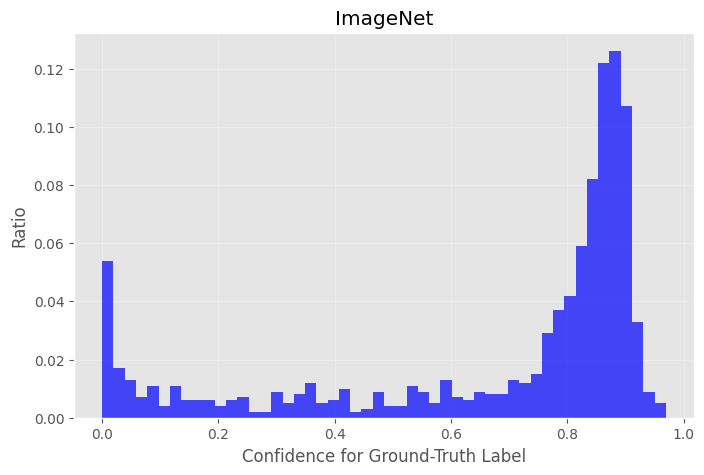

In [53]:
# 기능 4: confidence를 입력으로 받았을 때, histogram 그리기
def plot_confidence_histogram(
    confidences: np.ndarray,
    bins: int = 50,
    title: str = "GT Label Confidence Distribution",
    xlabel: str = "Confidence for Ground-Truth Label",
    ylabel: str = "Ratio",
    save_path: Optional[str] = None,
    show: bool = True,
    figsize: Tuple[int, int] = (8, 5),
    alpha: float = 0.7,
    color: str = "blue",
    use_ratio: bool = True,
):
    plt.figure(figsize=figsize)
    
    if use_ratio:
        # 비율로 표시 (총합 = 1)
        weights = np.ones(len(confidences)) / len(confidences)
        plt.hist(confidences, bins=bins, weights=weights, alpha=alpha, color=color)
    else:
        # Density로 표시 (면적 = 1)
        plt.hist(confidences, bins=bins, density=True, alpha=alpha, color=color)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    if show:
        plt.show()
    
    plt.close()

##################################################
################## 코드 실행 부분 ###################
##################################################

# For ImageNet Dataset
save_path = os.path.join(BASE_DIR + "ImageNet")
plot_confidence_histogram(
    confidences=imagenet_confidence,
    title="ImageNet",
    save_path=save_path,
)

In [ ]:
# For Synthetic Dataset
# save_path = os.path.join(BASE_DIR + "Synthetic")
# plot_confidence_histogram(
#     confidences=synthetic_confidence,
#     title="Synthetic",
#     save_path=save_path,
# )

In [ ]:
# # Utility
# def print_confidence_stats(
#     confidences: np.ndarray,
#     name: str = "Dataset"
# ):
#     print(f"\n=== {name} Confidence Statistics ===")
#     print(f"  Count: {len(confidences)}")
#     print(f"  Mean:  {confidences.mean():.4f}")
#     print(f"  Std:   {confidences.std():.4f}")
#     print(f"  Min:   {confidences.min():.4f}")
#     print(f"  Max:   {confidences.max():.4f}")
#     print(f"  Median: {np.median(confidences):.4f}")

### OLD: label을 고려하지 않고, 특정 숫자만큼의 이미지를 생성 및 비교

#### Synthetic dataset (DeepInversion & Sparse Model Inversion)

In [ ]:
# import os
# import glob
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# # GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# torch.manual_seed(0)
# np.random.seed(0)

# plt.style.use("ggplot")
# plt.rcParams["figure.figsize"] = (8, 5)
# plt.rcParams["axes.grid"] = True

# print("Environment setup completed.")

Using device: cuda
Environment setup completed.


In [ ]:
# # 기본 옵션 설정하기
# # BASE_DIR = "./dataset/deit_base_16_imagenet/DMI_Seed" # DeepInversion
# BASE_DIR = "./dataset/deit_base_16_imagenet/SMI_Seed" # Sparse Model Inversion
# SEED_RANGE = range(1, 51)

# MODEL_NAME = "deit_base_16_imagenet"

# BIN_EDGES = np.linspace(0.0, 1.0, 11)  # [0.0, 0.1, ..., 1.0]

# DEBUG_MODE = False
# DEBUG_MAX_IMAGES = 20

# # OUTPUT_DIR = "./observation/08_Confidence/DMI" # DeepInversion
# OUTPUT_DIR = "./observation/08_Confidence/SMI" # Sparse Model Inversion
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# print("Configuration loaded:")
# print(f"- Base directory: {BASE_DIR}")
# print(f"- Seeds: 1 to 50 ({len(SEED_RANGE)} seeds)")
# print(f"- Model name: {MODEL_NAME}")
# print(f"- Histogram bins: {BIN_EDGES}")
# print(f"- Debug mode: {DEBUG_MODE}")

Configuration loaded:
- Base directory: ./dataset/deit_base_16_imagenet/SMI_Seed
- Seeds: 1 to 50 (50 seeds)
- Model name: deit_base_16_imagenet
- Histogram bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
- Debug mode: False


In [ ]:
# # Seed 별 targets 불러오기 & path_to_target 매핑

# import re
# import json

# def numeric_sort_key(path):
#     fname = os.path.basename(path)
#     m = re.match(r"(\d+)-(\d+)\.png$", fname)
#     if m is None:
#         raise ValueError(f"Unexpected filename format: {fname}")
#     return (int(m.group(1)), int(m.group(2)))

# TARGET_BASE_DIR = "./observation/06_Saliency_Analysis/targets"

# path_to_target = {}
# missing_target_paths = []

# for seed in SEED_RANGE:
#     # folder_name = f"DMI-4000-{seed}-32-W4A8" # DeepInversion
#     folder_name = f"SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-{seed}-32-W4A8" # Sparse Model Inversion
#     folder_path = os.path.join(BASE_DIR, folder_name)
#     # img_paths = sorted(glob.glob(os.path.join(folder_path, "*.png")))
#     # TODO: saliency 실험에 추가하기 (img_path 정렬하는 코드임)
#     img_paths = sorted(glob.glob(os.path.join(folder_path, "*.png")), key=numeric_sort_key)
#     if len(img_paths) == 0:
#         print(f"Seed {seed}: 이미지가 없습니다. ({folder_path})")
#         continue

#     target_file = os.path.join(TARGET_BASE_DIR, f"saliency_seed_{seed}.txt")
#     if not os.path.isfile(target_file):
#         print(f"Seed {seed}: 타겟 파일이 없습니다. ({target_file}) → 이 seed는 argmax로 saliency 계산 예정")
#         for p in img_paths:
#             path_to_target[p] = None
#             missing_target_paths.append(p)
#         continue

#     with open(target_file, "r") as f:
#         data = json.load(f)

#     targets_seed = data.get("targets", None)
#     if targets_seed is None:
#         print(f"Seed {seed}: 파일에 'targets' 키가 없습니다. ({target_file})")
#         for p in img_paths:
#             path_to_target[p] = None
#             missing_target_paths.append(p)
#         continue

#     if len(targets_seed) != len(img_paths):
#         print(f"Seed {seed}: 타겟 개수({len(targets_seed)})와 이미지 개수({len(img_paths)})가 다릅니다.")
#         min_len = min(len(targets_seed), len(img_paths))
#         print(f"   → 앞 {min_len}개만 매핑합니다.")
#     else:
#         min_len = len(img_paths)

#     for img_path, t in zip(img_paths[:min_len], targets_seed[:min_len]):
#         path_to_target[img_path] = int(t)

# print("-" * 60)
# print(f"총 매핑된 이미지 개수: {len(path_to_target)}")
# print(f"타겟이 없는(missing) 이미지 개수: {len(missing_target_paths)}")
# print("샘플 5개 매핑 예시:")
# for p in list(path_to_target.keys())[:5]:
#     print(" ", p, "→", path_to_target[p])

------------------------------------------------------------
총 매핑된 이미지 개수: 1600
타겟이 없는(missing) 이미지 개수: 0
샘플 5개 매핑 예시:
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-0.png → 6
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-1.png → 16
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-2.png → 30
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-3.png → 71
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-4.png → 72


In [ ]:
# # target 별 이미지 개수 저장

# from collections import defaultdict
# import json
# import os

# TARGET_STATS_PATH = os.path.join(OUTPUT_DIR, "target_stats.json")

# target_count = defaultdict(int)
# target_to_paths = defaultdict(list)

# for img_path, target_class in path_to_target.items():
#     if target_class is None:
#         continue

#     target_count[target_class] += 1
#     target_to_paths[target_class].append(img_path)

# target_stats = {
#     "num_classes": len(target_count),
#     "counts": target_count,  # label마다 몇 장인지
#     "paths_per_label": target_to_paths  # label → 이미지 경로 리스트 (원하면 삭제 가능)
# }

# # defaultdict는 JSON 직렬화가 안 되므로 dict로 변환
# target_stats["counts"] = dict(target_stats["counts"])
# target_stats["paths_per_label"] = {int(k): v for k, v in target_stats["paths_per_label"].items()}

# with open(TARGET_STATS_PATH, "w") as f:
#     json.dump(target_stats, f, indent=4)

# print(f"Target별 이미지 개수를 다음 파일에 저장했습니다:\n  {TARGET_STATS_PATH}")

# # 통계 요약
# print("\n label별 이미지 개수 일부 예시:")
# for label, cnt in list(target_stats["counts"].items())[:10]:
#     print(f"  class {label}: {cnt} images")


Target별 이미지 개수를 다음 파일에 저장했습니다:
  ./observation/08_Confidence/SMI/target_stats.json

 label별 이미지 개수 일부 예시:
  class 6: 1 images
  class 16: 4 images
  class 30: 4 images
  class 71: 4 images
  class 72: 3 images
  class 79: 2 images
  class 122: 3 images
  class 137: 1 images
  class 138: 4 images
  class 145: 3 images


In [ ]:
# # Pre-trained model 불러오기

# from utils import build_model

# def get_teacher(name):
#     teacher_name = {'deit_tiny_16_imagenet': 'deit_tiny_patch16_224',
#                     'deit_base_16_imagenet': 'deit_base_patch16_224',
#                     }
#     if name.split("_")[-1]=='imagenet':
#         teacher=build_model(teacher_name[name], Pretrained=True)
#     else:
#         raise NotImplementedError
#     return teacher

# print(f"Loading teacher model: {MODEL_NAME}")
# model = get_teacher(MODEL_NAME)
# model = model.to(device)
# model.eval()

# for p in model.parameters():
#     p.requires_grad = True

# num_params = sum(p.numel() for p in model.parameters())
# num_params_m = num_params / 1e6

# print(f"Teacher model loaded on device: {device}")
# print(f"#Params: {num_params_m:.2f}M ({num_params:,} parameters)")

Loading teacher model: deit_base_16_imagenet
Teacher model loaded on device: cuda
#Params: 86.57M (86,567,656 parameters)


In [ ]:
# # 이미지 경로 수집 & 데이터셋 인덱싱
# image_paths = []

# for seed in SEED_RANGE:
#     # folder_name = f"DMI-4000-{seed}-32-W4A8" # DeepInversion
#     folder_name = f"SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-{seed}-32-W4A8" # Sparse Model Inversion
#     folder_path = os.path.join(BASE_DIR, folder_name)
    
#     if not os.path.isdir(folder_path):
#         print(f"폴더가 존재하지 않습니다: {folder_path}")
#         continue

#     pattern = os.path.join(folder_path, "*.png")
#     paths_in_folder = sorted(glob.glob(pattern))
    
#     if len(paths_in_folder) == 0:
#         print(f"이미지가 없는 폴더입니다: {folder_path}")
#     else:
#         print(f"Seed {seed:2d}: {len(paths_in_folder)} images")
    
#     image_paths.extend(paths_in_folder)

# num_images_total = len(image_paths)
# print("-" * 50)
# print(f"총 이미지 개수 (수집된 경로 기준): {num_images_total}")

# if DEBUG_MODE:
#     original_count = len(image_paths)
#     image_paths = image_paths[:DEBUG_MAX_IMAGES]
#     print(f"DEBUG_MODE = True → {original_count}개 중 상위 {len(image_paths)}개 이미지만 사용합니다.")

# print("-" * 50)
# print("샘플 이미지 경로 5개 예시:")
# for p in image_paths[:5]:
#     print("  ", p)

Seed  1: 32 images
Seed  2: 32 images
Seed  3: 32 images
Seed  4: 32 images
Seed  5: 32 images
Seed  6: 32 images
Seed  7: 32 images
Seed  8: 32 images
Seed  9: 32 images
Seed 10: 32 images
Seed 11: 32 images
Seed 12: 32 images
Seed 13: 32 images
Seed 14: 32 images
Seed 15: 32 images
Seed 16: 32 images
Seed 17: 32 images
Seed 18: 32 images
Seed 19: 32 images
Seed 20: 32 images
Seed 21: 32 images
Seed 22: 32 images
Seed 23: 32 images
Seed 24: 32 images
Seed 25: 32 images
Seed 26: 32 images
Seed 27: 32 images
Seed 28: 32 images
Seed 29: 32 images
Seed 30: 32 images
Seed 31: 32 images
Seed 32: 32 images
Seed 33: 32 images
Seed 34: 32 images
Seed 35: 32 images
Seed 36: 32 images
Seed 37: 32 images
Seed 38: 32 images
Seed 39: 32 images
Seed 40: 32 images
Seed 41: 32 images
Seed 42: 32 images
Seed 43: 32 images
Seed 44: 32 images
Seed 45: 32 images
Seed 46: 32 images
Seed 47: 32 images
Seed 48: 32 images
Seed 49: 32 images
Seed 50: 32 images
--------------------------------------------------

In [ ]:
# # DataLoader 구성하기
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

# class ImageDataset(Dataset):
#     """이미지 경로와 타겟을 로드하는 커스텀 Dataset"""
#     def __init__(self, path_to_target, transform=None):
#         self.image_paths = list(path_to_target.keys())
#         self.targets = list(path_to_target.values())
#         self.transform = transform
    
#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path).convert('RGB')
#         target = self.targets[idx]
        
#         if self.transform:
#             image = self.transform(image)
        
#         # target이 None인 경우 -1로 반환 (나중에 argmax로 처리)
#         if target is None:
#             target = -1
        
#         return image, target, img_path

# # ImageNet 정규화를 위한 transform 설정
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Dataset 및 DataLoader 생성
# dataset = ImageDataset(path_to_target, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# print(f"Dataset 크기: {len(dataset)}")
# print(f"DataLoader 배치 수: {len(dataloader)}")

# # 첫 배치 확인
# images, targets, paths = next(iter(dataloader))
# print(f"이미지 배치 shape: {images.shape}")
# print(f"타겟 배치: {targets[:5]}")
# print(f"경로 예시: {paths[0]}")

Dataset 크기: 1600
DataLoader 배치 수: 50
이미지 배치 shape: torch.Size([32, 3, 224, 224])
타겟 배치: tensor([ 6, 16, 30, 71, 72])
경로 예시: ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-0.png


In [ ]:
# # 시각화 함수 정의

# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# @torch.no_grad()
# def plot_gt_confidence_distribution(
#     model,
#     dataloader,
#     device="cuda",
#     bins=50,
#     use_softmax=True
# ):
#     """
#     model: image classification model (logits output assumed)
#     dataloader: yields (images, labels)
#     device: 'cuda' or 'cpu'
#     bins: histogram bins
#     use_softmax: True if model outputs logits
#     """
#     model.eval()
#     model.to(device)

#     # Inference 용도
#     num_patches = 197
#     current_abs_index = torch.LongTensor(list(range(num_patches))).repeat(32, 1).to(device)
#     next_relative_index = torch.LongTensor(list(range(num_patches))).repeat(32, 1).to(device)

#     confidences = []

#     for images, labels, _ in dataloader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images, current_abs_index, next_relative_index)          # (B, C)

#         if isinstance(outputs, tuple):
#             outputs = outputs[0]

#         if use_softmax:
#             probs = F.softmax(outputs, dim=1)
#         else:
#             probs = outputs               # already probabilities
#         gt_conf = probs.gather(1, labels.unsqueeze(1))  # (B, 1)
#         confidences.append(gt_conf.squeeze(1).cpu())

#     confidences = torch.cat(confidences).numpy()
#     print(confidences)
#     # visualization
#     plt.figure()
#     # plt.hist(confidences, bins=bins, density=True) # 아래 면적이 1이 되도록
#     plt.hist(confidences, bins=bins, weights=np.ones(len(confidences)) / len(confidences)) # 비율
#     plt.xlabel("Confidence for Ground-Truth Label")
#     plt.ylabel("Density")
#     plt.title("GT Label Confidence Distribution")
#     plt.show()


[0.00038163 0.01905491 0.04568592 ... 0.12980226 0.0004435  0.02433667]


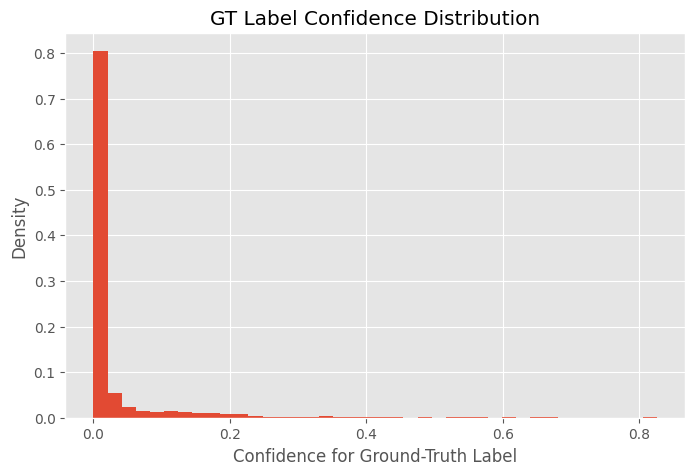

In [ ]:
# plot_gt_confidence_distribution(
#     model,
#     dataloader,
#     device="cuda",
#     bins=40
# )

<!-- #### 실제 이미지 (ImageNet) -->

In [ ]:
# import json
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader, Subset
# import torchvision
# from torchvision import transforms, datasets
# import random

# # target_stats.json 로드
# STATS_FILE = "./observation/08_Confidence/DMI/target_stats.json"
# with open(STATS_FILE, "r") as f:
#     target_stats = json.load(f)

# class_counts = target_stats["counts"]  # {"label_id": count, ...}
# print(f"클래스 수: {len(class_counts)}")
# print(f"총 이미지 수: {sum(class_counts.values())}")

# # ImageNet validation 데이터셋 경로 설정 (본인 환경에 맞게 수정)
# IMAGENET_VAL_DIR = "/home/mjatwk/data/imagenet/"

# # Transform 설정 (합성 이미지와 동일하게)
# transform_imagenet = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # ImageNet Validation 데이터셋 로드
# val_dataset_full = torchvision.datasets.ImageNet(
#     root=IMAGENET_VAL_DIR, split='val', transform=transform_imagenet
# )

# # 클래스별 인덱스 매핑 생성
# # ImageFolder는 자동으로 폴더명 기준 정렬된 class_to_idx 사용
# class_to_indices = {}
# for idx, (_, label) in enumerate(val_dataset_full.samples):
#     if label not in class_to_indices:
#         class_to_indices[label] = []
#     class_to_indices[label].append(idx)

# print(f"ImageNet validation 전체 클래스 수: {len(class_to_indices)}")

# # target_stats와 동일한 분포로 샘플링
# sampled_indices = []
# missing_classes = []

# random.seed(0)  # 재현성을 위한 시드 설정

# for class_id_str, count in class_counts.items():
#     class_id = int(class_id_str)
    
#     if class_id not in class_to_indices:
#         missing_classes.append(class_id)
#         continue
    
#     available_indices = class_to_indices[class_id]
    
#     # 요청 개수만큼 샘플링 (available보다 많으면 중복 허용)
#     if len(available_indices) >= count:
#         sampled = random.sample(available_indices, count)
#     else:
#         # 이미지가 부족하면 중복 샘플링
#         sampled = random.choices(available_indices, k=count)
#         print(f"Warning: Class {class_id}에서 {count}개 요청했지만 {len(available_indices)}개만 존재. 중복 샘플링 수행.")
    
#     sampled_indices.extend(sampled)

# print(f"\n샘플링 완료:")
# print(f"- 총 샘플링된 이미지 수: {len(sampled_indices)}")
# print(f"- 누락된 클래스 수: {len(missing_classes)}")
# if missing_classes:
#     print(f"- 누락 클래스 (최대 10개): {missing_classes[:10]}")

# # Subset 데이터셋 생성
# imagenet_sampled_dataset = Subset(val_dataset_full, sampled_indices)

# # DataLoader 생성
# imagenet_dataloader = DataLoader(
#     imagenet_sampled_dataset, 
#     batch_size=32, 
#     shuffle=False, 
#     num_workers=4
# )

# print(f"\nDataLoader 생성 완료:")
# print(f"- 배치 수: {len(imagenet_dataloader)}")

# # 첫 배치 확인
# images, targets = next(iter(imagenet_dataloader))
# print(f"- 이미지 배치 shape: {images.shape}")
# print(f"- 타겟 예시: {targets[:5].tolist()}")

클래스 수: 809
총 이미지 수: 1600
ImageNet validation 전체 클래스 수: 1000

샘플링 완료:
- 총 샘플링된 이미지 수: 1600
- 누락된 클래스 수: 0

DataLoader 생성 완료:
- 배치 수: 50
- 이미지 배치 shape: torch.Size([32, 3, 224, 224])
- 타겟 예시: [6, 16, 16, 16, 16]


In [ ]:
# # 시각화 함수 정의

# import torch
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# @torch.no_grad()
# def plot_gt_confidence_distribution_imagenet(
#     model,
#     dataloader,
#     device="cuda",
#     bins=50,
#     use_softmax=True
# ):
#     """
#     model: image classification model (logits output assumed)
#     dataloader: yields (images, labels)
#     device: 'cuda' or 'cpu'
#     bins: histogram bins
#     use_softmax: True if model outputs logits
#     """
#     model.eval()
#     model.to(device)

#     # Inference 용도
#     num_patches = 197
#     current_abs_index = torch.LongTensor(list(range(num_patches))).repeat(32, 1).to(device)
#     next_relative_index = torch.LongTensor(list(range(num_patches))).repeat(32, 1).to(device)

#     confidences = []

#     for images, labels in dataloader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images, current_abs_index, next_relative_index)          # (B, C)

#         if isinstance(outputs, tuple):
#             outputs = outputs[0]

#         if use_softmax:
#             probs = F.softmax(outputs, dim=1)
#         else:
#             probs = outputs               # already probabilities

#         gt_conf = probs.gather(1, labels.unsqueeze(1))  # (B, 1)
#         confidences.append(gt_conf.squeeze(1).cpu())

#     confidences = torch.cat(confidences).numpy()

#     # visualization
#     plt.figure()
#     # plt.hist(confidences, bins=bins, density=True) # 아래 면적이 1이 되도록
#     plt.hist(confidences, bins=bins, weights=np.ones(len(confidences)) / len(confidences)) # 비율
#     plt.xlabel("Confidence for Ground-Truth Label")
#     plt.ylabel("Density")
#     plt.title("GT Label Confidence Distribution")
#     plt.show()


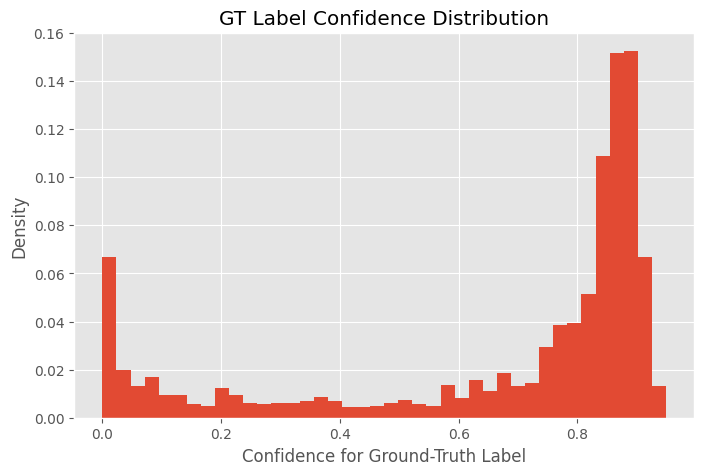

In [ ]:
# plot_gt_confidence_distribution_imagenet(
#     model,
#     imagenet_dataloader,
#     device="cuda",
#     bins=40
# )